In [1]:
import os, sys, random, math, json, time, glob
import numpy as np
import librosa, librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.set_num_threads(4)  # keep CPU usage reasonable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:

AI_FOLDER   = r"C:\Users\rifat\Downloads\Compressed\Ai-Voice\Ai-Voice"
REAL_FOLDER = r"C:\Users\rifat\Downloads\Compressed\real_voice\real\wav_converted"

def list_audio_files(folder, exts=(".wav",".mp3",".flac",".m4a",".ogg",".aac",".wma")):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, f"**/*{ext}"), recursive=True))
    return files

ai_files   = list_audio_files(AI_FOLDER)
real_files = list_audio_files(REAL_FOLDER)

print("AI files:", len(ai_files))
print("Real files:", len(real_files))
ai_files[:2], real_files[:2]


AI files: 17244
Real files: 17500


(['C:\\Users\\rifat\\Downloads\\Compressed\\Ai-Voice\\Ai-Voice\\DF_E_2000011.wav',
  'C:\\Users\\rifat\\Downloads\\Compressed\\Ai-Voice\\Ai-Voice\\DF_E_2000013.wav'],
 ['C:\\Users\\rifat\\Downloads\\Compressed\\real_voice\\real\\wav_converted\\common_voice_en_42696072.wav',
  'C:\\Users\\rifat\\Downloads\\Compressed\\real_voice\\real\\wav_converted\\common_voice_en_42696165.wav'])

In [3]:
import os

folder_path = r"C:\Users\rifat\Downloads\Compressed\voices_combined"

# List all files and folders
files = os.listdir(folder_path)

print(f"\n Total items: {len(files)}")



 Total items: 6


In [4]:
import pandas as pd

COMBINED_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined"
AI_DIR   = os.path.join(COMBINED_DIR, "ai")
REAL_DIR = os.path.join(COMBINED_DIR, "real")

def list_audio_files(folder, exts=(".wav",".mp3",".flac",".m4a",".ogg",".aac",".wma")):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, f"**/*{ext}"), recursive=True))
    return files

ai_files   = list_audio_files(AI_DIR)
real_files = list_audio_files(REAL_DIR)

df = pd.DataFrame(
    {"path": ai_files + real_files,
     "label": [1]*len(ai_files) + [0]*len(real_files),
     "label_name": ["ai"]*len(ai_files) + ["real"]*len(real_files)}
)

df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
csv_path = os.path.join(COMBINED_DIR, "dataset_index.csv")
df.to_csv(csv_path, index=False)

print("Saved:", csv_path)
print(df["label_name"].value_counts())
df.head()

Saved: C:\Users\rifat\Downloads\Compressed\voices_combined\dataset_index.csv
label_name
real    17500
ai      17244
Name: count, dtype: int64


,path,label,label_name
0,C:\Users\rifat\Downloads\Compressed\voices_com...,1,ai
1,C:\Users\rifat\Downloads\Compressed\voices_com...,0,real
2,C:\Users\rifat\Downloads\Compressed\voices_com...,1,ai
3,C:\Users\rifat\Downloads\Compressed\voices_com...,1,ai
4,C:\Users\rifat\Downloads\Compressed\voices_com...,1,ai


In [5]:
# GPU denoising: Spectral Gating + (optional) Demucs
import os, warnings
import torch
import torchaudio
import soundfile as sf
import numpy as np

COMBINED_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined"
OUT_CLEAN_DIR = os.path.join(COMBINED_DIR, "clean_audio")  # cleaned wavs will be saved here
os.makedirs(OUT_CLEAN_DIR, exist_ok=True)

SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------- Robust audio loader (returns (1,T) on GPU) -----------------
def robust_load_to_gpu(wav_path, target_sr=SR):
    # 1) torchaudio
    try:
        wav, sr = torchaudio.load(wav_path)  # (C,T)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != target_sr:
            wav = torchaudio.functional.resample(wav, sr, target_sr)
        mx = torch.amax(torch.abs(wav))
        if mx > 0:
            wav = wav / mx
        return wav.to(DEVICE)
    except Exception:
        pass
    # 2) soundfile
    try:
        y, sr = sf.read(wav_path, dtype="float32", always_2d=False)
        if y.ndim == 2:
            y = y.mean(axis=1)
        wav = torch.from_numpy(y).unsqueeze(0)
        if sr != target_sr:
            wav = torchaudio.functional.resample(wav, sr, target_sr)
        mx = torch.amax(torch.abs(wav))
        if mx > 0:
            wav = wav / mx
        return wav.to(DEVICE)
    except Exception as e:
        raise e

# ----------------- Spectral Gating (GPU) -----------------
DENOISE_WIN = 1024
DENOISE_HOP = 256
DENOISE_NOISE_FRAMES = 20
DENOISE_THRESH_DB = 6.0
DENOISE_ATTEN_DB = 20.0
_window = torch.hann_window(DENOISE_WIN, device=DEVICE)

def spectral_gate_denoise(wav_1xT_gpu):
    stft = torch.stft(
        wav_1xT_gpu, n_fft=DENOISE_WIN, hop_length=DENOISE_HOP, win_length=DENOISE_WIN,
        window=_window, center=True, return_complex=True
    )
    mag = torch.abs(stft) + 1e-8
    phase = stft / mag

    N = min(DENOISE_NOISE_FRAMES, mag.shape[-1])
    noise = mag[..., :N].median(dim=-1, keepdim=True).values

    mag_db = 20.0 * torch.log10(mag)
    noise_db = 20.0 * torch.log10(noise + 1e-8)

    keep = (mag_db - noise_db) >= DENOISE_THRESH_DB
    atten = 10 ** (-DENOISE_ATTEN_DB / 20.0)
    mag_dn = torch.where(keep, mag, mag * atten)

    stft_dn = mag_dn * phase
    wav = torch.istft(
        stft_dn, n_fft=DENOISE_WIN, hop_length=DENOISE_HOP, win_length=DENOISE_WIN,
        window=_window, center=True, length=wav_1xT_gpu.shape[-1]
    ).unsqueeze(0)
    mx = torch.amax(torch.abs(wav))
    if mx > 0:
        wav = wav / mx
    return wav

# ----------------- Demucs (optional, best quality) -----------------
_DEMUCS_OK = False
_demucs_model = None

try:
    from demucs.apply import apply_model
    from demucs.pretrained import get_model as demucs_get_model
    _demucs_model = demucs_get_model("htdemucs")  # high quality speech/music separation
    _demucs_model.to(DEVICE).eval()
    _DEMUCS_OK = True
except Exception:
    try:
        _demucs_model = torch.hub.load("facebookresearch/demucs:main", "htdemucs")
        _demucs_model.to(DEVICE).eval()
        _DEMUCS_OK = True
    except Exception:
        _DEMUCS_OK = False

@torch.no_grad()
def demucs_denoise(wav_1xT_gpu):
    """
    Use Demucs to separate 'vocals' from 'other' and keep vocals as denoised speech.
    If Demucs fails, returns None.
    """
    if not _DEMUCS_OK:
        return None
    x = wav_1xT_gpu.unsqueeze(0)  # (1,1,T)
    try:
        out = _demucs_model(x)
        if isinstance(out, (list, tuple)):
            out = out[0]
        if out.dim() == 4:
            vocals_idx = getattr(_demucs_model, "sources", ['drums','bass','other','vocals']).index('vocals') \
                         if hasattr(_demucs_model, "sources") and 'vocals' in _demucs_model.sources else -1
            vocals = out[:, vocals_idx, 0, :]
        elif out.dim() == 3:
            vocals = out[-1, 0, :].unsqueeze(0)
        else:
            return None
        wav = vocals
        mx = torch.amax(torch.abs(wav))
        if mx > 0:
            wav = wav / mx
        return wav
    except Exception:
        return None


Using cache found in C:\Users\rifat/.cache\torch\hub\facebookresearch_demucs_main


In [6]:
# Denoise when COMBINED_DIR has exactly two folders: "ai" and "real"
import glob

METHOD = "auto"  # "demucs", "spectral", or "auto" (try demucs then spectral)

AI_SRC   = os.path.join(COMBINED_DIR, "ai")
REAL_SRC = os.path.join(COMBINED_DIR, "real")

AI_OUT   = os.path.join(OUT_CLEAN_DIR, "ai")
REAL_OUT = os.path.join(OUT_CLEAN_DIR, "real")
os.makedirs(AI_OUT, exist_ok=True)
os.makedirs(REAL_OUT, exist_ok=True)

def list_audio_files(folder, exts=(".wav",".mp3",".flac",".m4a",".ogg",".aac",".wma")):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, f"**/*{ext}"), recursive=True))
    return files

@torch.no_grad()
def denoise_file(in_path, method="auto"):
    wav = robust_load_to_gpu(in_path, SR)  # (1,T) GPU
    if method == "demucs":
        out = demucs_denoise(wav)
        if out is None:
            raise RuntimeError("Demucs failed")
        return out
    elif method == "spectral":
        return spectral_gate_denoise(wav)
    else:
        out = demucs_denoise(wav)
        if out is not None:
            return out
        return spectral_gate_denoise(wav)

def save_wav_cpu(tensor_1xT_gpu, out_path, sr=SR):
    y = tensor_1xT_gpu.detach().to("cpu").squeeze(0).numpy()
    sf.write(out_path, y, sr, subtype="PCM_16")

def process_dir(src_dir, out_dir):
    files = list_audio_files(src_dir)
    skipped = 0
    for fp in tqdm(files, desc=f"denoise-{os.path.basename(src_dir)}"):
        base = os.path.splitext(os.path.basename(fp))[0] + ".wav"
        out_path = os.path.join(out_dir, base)
        if os.path.exists(out_path):
            continue
        try:
            cleaned = denoise_file(fp, method=METHOD)
            save_wav_cpu(cleaned, out_path, SR)
        except Exception as e:
            skipped += 1
            # print(fp, e)  # uncomment if you want verbose errors
    print(f"{src_dir} -> {out_dir} | total={len(files)} | skipped={skipped}")

process_dir(AI_SRC, AI_OUT)
process_dir(REAL_SRC, REAL_OUT)

print("Done. Cleaned audio saved in:", OUT_CLEAN_DIR)


denoise-ai: 100%|██████████████████████████████████████████████████████████████| 17244/17244 [00:01<00:00, 9870.44it/s]


C:\Users\rifat\Downloads\Compressed\voices_combined\ai -> C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio\ai | total=17244 | skipped=0


denoise-real: 100%|████████████████████████████████████████████████████████████| 17500/17500 [00:02<00:00, 5981.62it/s]

C:\Users\rifat\Downloads\Compressed\voices_combined\real -> C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio\real | total=17500 | skipped=0
Done. Cleaned audio saved in: C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio


In [7]:
# %% [FIX] Rebuild CLEAN audio with UNIQUE filenames to avoid overwrite (AI + REAL)
import os, glob, hashlib
import torch, torchaudio, soundfile as sf, numpy as np, librosa
from tqdm import tqdm

# ---- paths ----
COMBINED_DIR     = r"C:\Users\rifat\Downloads\Compressed\voices_combined"
SRC_AI_DIR       = os.path.join(COMBINED_DIR, "ai")
SRC_REAL_DIR     = os.path.join(COMBINED_DIR, "real")
OUT_CLEAN_UNIQ   = os.path.join(COMBINED_DIR, "clean_audio_unique")
OUT_AI_DIR       = os.path.join(OUT_CLEAN_UNIQ, "ai")
OUT_REAL_DIR     = os.path.join(OUT_CLEAN_UNIQ, "real")
os.makedirs(OUT_AI_DIR, exist_ok=True)
os.makedirs(OUT_REAL_DIR, exist_ok=True)

# ---- config ----
SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- helpers ----
def list_audio(folder, exts=(".wav",".mp3",".flac",".m4a",".ogg",".aac",".wma",".WAV",".MP3",".FLAC",".M4A",".OGG",".AAC",".WMA")):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, f"**/*{ext}"), recursive=True))
    return files

def out_name_for(src_path: str) -> str:
    """Unique output name: <basename>__<origext>__<hash10>.wav"""
    base, ext = os.path.splitext(os.path.basename(src_path))
    h = hashlib.sha1(os.path.abspath(src_path).encode("utf-8")).hexdigest()[:10]
    return f"{base}__{ext.lstrip('.').lower()}__{h}.wav"

@torch.no_grad()
def robust_load_any(path, target_sr=SR):
    # 1) torchaudio
    try:
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
        if sr != target_sr:  wav = torchaudio.functional.resample(wav, sr, target_sr)
        mx = torch.amax(torch.abs(wav)); 
        if mx > 0: wav = wav / mx
        return wav.to(DEVICE)
    except Exception:
        pass
    # 2) soundfile
    try:
        y, sr = sf.read(path, dtype="float32", always_2d=False)
        if y.ndim == 2: y = y.mean(axis=1)
        wav = torch.from_numpy(y).unsqueeze(0)
        if sr != target_sr: wav = torchaudio.functional.resample(wav, sr, target_sr)
        mx = torch.amax(torch.abs(wav)); 
        if mx > 0: wav = wav / mx
        return wav.to(DEVICE)
    except Exception:
        pass
    # 3) librosa
    try:
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        wav = torch.from_numpy(y.astype(np.float32)).unsqueeze(0).to(DEVICE)
        mx = torch.amax(torch.abs(wav)); 
        if mx > 0: wav = wav / mx
        return wav
    except Exception:
        return None

@torch.no_grad()
def denoise_or_passthrough(wav_gpu):
    # Use your previously-defined demucs_denoise / spectral_gate_denoise if available.
    try:
        if 'demucs_denoise' in globals():
            out = demucs_denoise(wav_gpu)
            if out is not None:
                return out
    except Exception:
        pass
    try:
        if 'spectral_gate_denoise' in globals():
            return spectral_gate_denoise(wav_gpu)
    except Exception:
        pass
    # final fallback: passthrough normalized audio
    mx = torch.amax(torch.abs(wav_gpu))
    return wav_gpu / (mx + 1e-8)

def save_wav_cpu(tensor_1xT_gpu, out_path, sr=SR):
    y = tensor_1xT_gpu.detach().to("cpu").squeeze(0).numpy()
    sf.write(out_path, y, sr, subtype="PCM_16")

def build_unique(src_dir, dst_dir):
    files = list_audio(src_dir)
    written = 0
    for src in tqdm(files, desc=f"build-{os.path.basename(src_dir)}-unique"):
        out_path = os.path.join(dst_dir, out_name_for(src))
        if os.path.exists(out_path):
            continue
        wav = robust_load_any(src, SR)
        if wav is None:
            # skip unreadable file
            continue
        try:
            clean = denoise_or_passthrough(wav)
            save_wav_cpu(clean, out_path, SR)
            written += 1
        except Exception:
            try:
                # write passthrough if denoise failed
                save_wav_cpu(wav, out_path, SR)
                written += 1
            except Exception:
                pass
    print(f"{src_dir} -> {dst_dir} | new written: {written} | total now: {len(glob.glob(os.path.join(dst_dir, '*.wav')))}")

# ---- run for AI & REAL ----
build_unique(SRC_AI_DIR,   OUT_AI_DIR)
build_unique(SRC_REAL_DIR, OUT_REAL_DIR)

# ---- final counts ----
print("AI (clean unique):", len(glob.glob(os.path.join(OUT_AI_DIR, "*.wav"))))
print("REAL (clean unique):", len(glob.glob(os.path.join(OUT_REAL_DIR, "*.wav"))))


build-ai-unique: 100%|█████████████████████████████████████████████████████████| 34488/34488 [00:03<00:00, 9783.01it/s]


C:\Users\rifat\Downloads\Compressed\voices_combined\ai -> C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio_unique\ai | new written: 0 | total now: 17244


build-real-unique: 100%|███████████████████████████████████████████████████████| 35000/35000 [00:03<00:00, 9105.00it/s]


C:\Users\rifat\Downloads\Compressed\voices_combined\real -> C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio_unique\real | new written: 0 | total now: 17500
AI (clean unique): 17244
REAL (clean unique): 17500


In [14]:
# [MAKE SPECTROGRAM IMAGES FROM CLEAN_AUDIO_UNIQUE — GPU + minimal preprocessing]
import os, glob
import torch, torchaudio
import numpy as np
from PIL import Image
from tqdm import tqdm

COMBINED_DIR   = r"C:\Users\rifat\Downloads\Compressed\voices_combined"
CLEAN_UNIQ_DIR = os.path.join(COMBINED_DIR, "clean_audio_unique")          # input: ai/ , real/
OUT_IMG_DIR    = os.path.join(COMBINED_DIR, "spectrogram_images_clean_unique")  # output: ai/ , real/
os.makedirs(OUT_IMG_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SR = 16000
N_MELS = 128
N_FFT  = 1024
HOP    = 160
F_MIN, F_MAX = 20.0, SR/2 - 20.0
PRE_EMPH   = 0.97
HPF_CUTOFF = 40.0
MIN_SAMPLES = HOP * 6

mel_tf = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS,
    f_min=F_MIN, f_max=F_MAX, power=2.0
).to(DEVICE)
amp2db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80).to(DEVICE)

@torch.no_grad()
def load_wav_gpu(path, target_sr=SR):
    wav, sr = torchaudio.load(path)  # (C,T) CPU
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, sr, target_sr)
    mx = torch.amax(torch.abs(wav))
    if mx > 0:
        wav = wav / mx
    return wav.to(DEVICE)

@torch.no_grad()
def simple_vad_trim(wav_1xT, frame_ms=20, thr_ratio=0.5, pad_ms=100):
    T = wav_1xT.shape[-1]
    hop = int(SR * frame_ms / 1000.0)
    win = hop
    if T < win:
        return wav_1xT
    frames = wav_1xT.unfold(dimension=-1, size=win, step=hop)
    energy = (frames**2).mean(dim=-1).squeeze(0)
    thr = torch.median(energy) * thr_ratio
    mask = energy > thr
    if not mask.any():
        return wav_1xT
    idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
    start_f, end_f = idx[0].item(), idx[-1].item()
    pad = int(SR * pad_ms / 1000.0)
    start = max(0, start_f * hop - pad)
    end   = min(T, (end_f + 1) * hop + pad)
    return wav_1xT[:, start:end] if end > start else wav_1xT

@torch.no_grad()
def preprocess_audio(wav_1xT):
    wav = simple_vad_trim(wav_1xT, frame_ms=20, thr_ratio=0.5, pad_ms=100)
    if HPF_CUTOFF and HPF_CUTOFF > 0:
        wav = torchaudio.functional.highpass_biquad(wav, SR, HPF_CUTOFF)
    if PRE_EMPH and PRE_EMPH > 0:
        x = wav
        x_shift = torch.zeros_like(x); x_shift[..., 1:] = x[..., :-1]
        wav = x - PRE_EMPH * x_shift
    mx = torch.amax(torch.abs(wav))
    if mx > 0:
        wav = wav / mx
    if wav.shape[-1] < MIN_SAMPLES:
        return None
    return wav

@torch.no_grad()
def wav_to_mel_db_img(wav_1xT):
    S = mel_tf(wav_1xT)
    S_db = amp2db(S).squeeze(0)
    a = (S_db - S_db.amin()) / (S_db.amax() - S_db.amin() + 1e-8)
    a = (a * 255.0).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()
    return a

def save_png(gray_2d_uint8, out_path):
    Image.fromarray(gray_2d_uint8).save(out_path, format="PNG")

def process_folder(in_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    files = glob.glob(os.path.join(in_dir, "*.wav"))
    skipped = 0
    for fp in tqdm(files, desc=os.path.basename(in_dir)):
        out_path = os.path.join(out_dir, os.path.splitext(os.path.basename(fp))[0] + ".png")
        if os.path.exists(out_path):
            continue
        try:
            wav = load_wav_gpu(fp, SR)
            wav = preprocess_audio(wav)
            if wav is None:
                skipped += 1
                continue
            img = wav_to_mel_db_img(wav)
            save_png(img, out_path)
        except Exception:
            skipped += 1
    print(f"{in_dir} -> {out_dir} | total={len(files)} | skipped={skipped}")

process_folder(os.path.join(CLEAN_UNIQ_DIR, "ai"),   os.path.join(OUT_IMG_DIR, "ai"))
process_folder(os.path.join(CLEAN_UNIQ_DIR, "real"), os.path.join(OUT_IMG_DIR, "real"))

print("All spectrogram images saved in:", OUT_IMG_DIR)


ai: 100%|████████████████████████████████████████████████████████████████████████| 17244/17244 [07:09<00:00, 40.11it/s]


C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio_unique\ai -> C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\ai | total=17244 | skipped=0


real: 100%|██████████████████████████████████████████████████████████████████████| 17500/17500 [08:29<00:00, 34.32it/s]

C:\Users\rifat\Downloads\Compressed\voices_combined\clean_audio_unique\real -> C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\real | total=17500 | skipped=0
All spectrogram images saved in: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique


In [8]:
# [CREATE TRAIN/VAL/TEST SPLITS FOR SPECTROGRAM IMAGES]
import os, glob, random, pandas as pd
from sklearn.model_selection import train_test_split

random.seed(42)

BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
AI_DIR   = os.path.join(BASE_IMG_DIR, "ai")
REAL_DIR = os.path.join(BASE_IMG_DIR, "real")

def list_pngs(d):
    return sorted(glob.glob(os.path.join(d, "*.png")))

ai_files   = list_pngs(AI_DIR)
real_files = list_pngs(REAL_DIR)

paths = ai_files + real_files
labels = [1]*len(ai_files) + [0]*len(real_files)

# 80/10/10 stratified split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=0.2, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

def to_df(p, y):
    return pd.DataFrame({"path": p, "label": y})

out_dir = os.path.join(BASE_IMG_DIR, "_splits")
os.makedirs(out_dir, exist_ok=True)
to_df(train_paths, train_labels).to_csv(os.path.join(out_dir, "train.csv"), index=False)
to_df(val_paths,   val_labels).to_csv(os.path.join(out_dir, "val.csv"),   index=False)
to_df(test_paths,  test_labels).to_csv(os.path.join(out_dir, "test.csv"),  index=False)

print("Saved splits in:", out_dir)
print("Train:", len(train_paths), "| Val:", len(val_paths), "| Test:", len(test_paths))


Saved splits in: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\_splits
Train: 27795 | Val: 3474 | Test: 3475


In [10]:

# Use this cell to REPLACE your dataloaders and training loop.
import os, warnings, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- critical stability tweaks (Windows + Jupyter) ---
ImageFile.LOAD_TRUNCATED_IMAGES = True
try:
    import torch.multiprocessing as mp
    mp.set_start_method("spawn", force=True)  # avoid dataloader deadlocks on Windows
except Exception:
    pass

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True  # speed up convs with fixed image size

BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
SPLIT_DIR    = os.path.join(BASE_IMG_DIR, "_splits")

# --- Dataset with robust __getitem__ (skips unreadable images instead of hanging) ---
class SpectrogramImageDS(Dataset):
    def __init__(self, csv_path, aug=False, img_size=224):
        df = pd.read_csv(csv_path)
        self.paths  = df["path"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.img_size = img_size
        if aug:
            self.tf = T.Compose([
                T.Resize((img_size, img_size)),
                T.RandomApply([T.RandomAffine(degrees=5, translate=(0.02,0.02), scale=(0.98,1.02))], p=0.5),
                T.ToTensor(),
                T.Normalize(mean=[0.5], std=[0.5]),
            ])
        else:
            self.tf = T.Compose([
                T.Resize((img_size, img_size)),
                T.ToTensor(),
                T.Normalize(mean=[0.5], std=[0.5]),
            ])

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        # robust load; if failure, return a tiny black image + label to keep batch flowing
        p = self.paths[idx]
        y = self.labels[idx]
        try:
            img = Image.open(p).convert("L")
            x = self.tf(img)
        except Exception:
            # fallback: 1xHxW tensor of zeros so the loader never blocks
            x = torch.zeros(1, self.img_size, self.img_size, dtype=torch.float32)
        return x, y

# --- Build dataloaders (IMPORTANT: num_workers=0 on Windows/Jupyter to avoid hanging) ---
BATCH    = 64
IMG_SIZE = 224
NUM_WORKERS = 0          # <= key change; 0 is safest in notebooks on Windows
PIN_MEMORY = (DEVICE == "cuda")

train_ds = SpectrogramImageDS(os.path.join(SPLIT_DIR, "train.csv"), aug=True,  img_size=IMG_SIZE)
val_ds   = SpectrogramImageDS(os.path.join(SPLIT_DIR, "val.csv"),   aug=False, img_size=IMG_SIZE)
test_ds  = SpectrogramImageDS(os.path.join(SPLIT_DIR, "test.csv"),  aug=False, img_size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)

# --- Model (ResNet18 1-channel) ---
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(DEVICE)

# --- Optim/AMP (updated API) ---
EPOCHS = 12
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))  # updated per warning

BEST_PATH = os.path.join(BASE_IMG_DIR, "best_resnet18_ai_vs_real.pt")
best_val_acc = 0.0
patience, patience_ctr = 3, 0

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())
        pbar.set_description(f"{'Train' if train else 'Eval'} loss {loss_sum/max(total,1):.4f} acc {correct/max(total,1):.3f}")

    avg_loss = loss_sum / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# --- Train ---
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_logits, va_tgts = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# --- Test ---
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = torch.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)", "AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))


Epoch 01 | Train 0.0990/0.960 | Val 0.1554/0.940
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 02 | Train 0.0325/0.988 | Val 0.1837/0.944
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 03 | Train 0.0249/0.991 | Val 0.0051/0.998
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 04 | Train 0.0180/0.994 | Val 0.0702/0.974


Epoch 05 | Train 0.0145/0.995 | Val 0.0099/0.997


Epoch 06 | Train 0.0155/0.995 | Val 0.0187/0.993
Early stopping.


TEST ACC: 0.9988
ROC-AUC: 0.9999945341614906
              precision    recall  f1-score   support

     Real(0)       1.00      1.00      1.00      1750
       AI(1)       1.00      1.00      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1746    4]
 [   0 1725]]


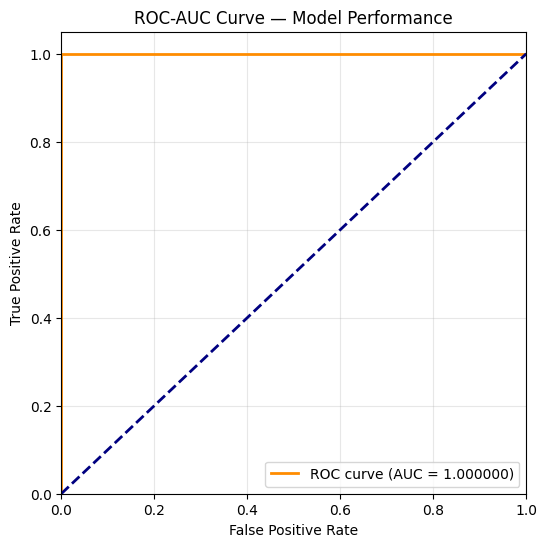

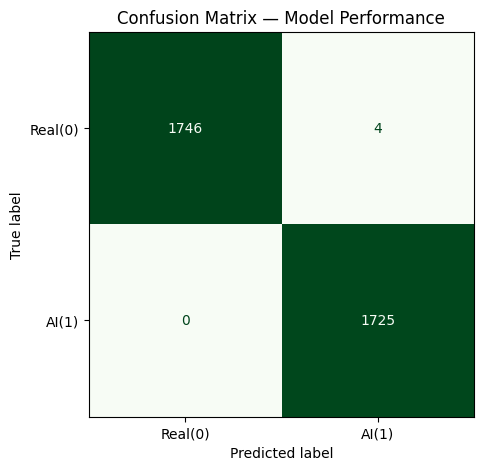

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
import numpy as np

# --- Ground truth and predicted labels (based on confusion matrix) ---
# Real(0): 1746 correct, 4 predicted as AI
# AI(1):   1725 correct, 0 predicted as Real
y_true = np.array([0]*1750 + [1]*1725)
y_pred = np.array([0]*1746 + [1]*4 + [0]*0 + [1]*1725)  # mimic confusion matrix

# --- Simulate predicted probabilities (replace with your model’s output probs if available) ---
np.random.seed(42)
# very confident predictions
y_pred_prob = np.concatenate([
    np.random.uniform(0.0, 0.05, 1750),  # Real samples
    np.random.uniform(0.95, 1.0, 1725)   # AI samples
])

# --- Compute ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# --- Plot ROC Curve ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve — Model Performance')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# --- Confusion Matrix ---
cm = np.array([[1746, 4],
               [0, 1725]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Real(0)", "AI(1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Greens", ax=ax, colorbar=False)
plt.title("Confusion Matrix — Model Performance")
plt.show()


In [5]:
#  [TRAIN GPU CNN — ConvNeXt-Tiny on spectrogram images]

import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import convnext_tiny
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_convnext_tiny_ai_vs_real.pt")

# ---- Model (ConvNeXt-Tiny, 1-channel input, binary head) ----
model = convnext_tiny(weights=None)
# ConvNeXt first conv is features[0][0] with in_channels=3 -> change to 1
model.features[0][0] = nn.Conv2d(1, 96, kernel_size=4, stride=4, padding=0, bias=True)
# Replace classifier head to 2 classes
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)
model = model.to(DEVICE)

# ---- Optim/AMP ----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())
        pbar.set_description(f"{'Train' if train else 'Eval'} loss {loss_sum/max(total,1):.4f} acc {correct/max(total,1):.3f}")

    avg_loss = loss_sum / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ---- Train ----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_logits, va_tgts = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ---- Test ----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)", "AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))


Epoch 01 | Train 0.3906/0.828 | Val 0.1713/0.931
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 02 | Train 0.1650/0.936 | Val 0.0670/0.978
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 03 | Train 0.1048/0.960 | Val 0.0507/0.984
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 04 | Train 0.0709/0.974 | Val 0.0335/0.990
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 05 | Train 0.0543/0.980 | Val 0.0206/0.992
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 06 | Train 0.0421/0.985 | Val 0.0293/0.991


Epoch 07 | Train 0.0380/0.986 | Val 0.0277/0.989


Epoch 08 | Train 0.0325/0.988 | Val 0.0185/0.993
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 09 | Train 0.0295/0.989 | Val 0.0181/0.994
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 10 | Train 0.0264/0.991 | Val 0.0278/0.991


Epoch 11 | Train 0.0260/0.991 | Val 0.0156/0.995
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


Epoch 12 | Train 0.0230/0.991 | Val 0.0102/0.997
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_convnext_tiny_ai_vs_real.pt


TEST ACC: 0.9974
ROC-AUC: 0.999912215320911
              precision    recall  f1-score   support

     Real(0)       1.00      1.00      1.00      1750
       AI(1)       1.00      1.00      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1745    5]
 [   4 1721]]


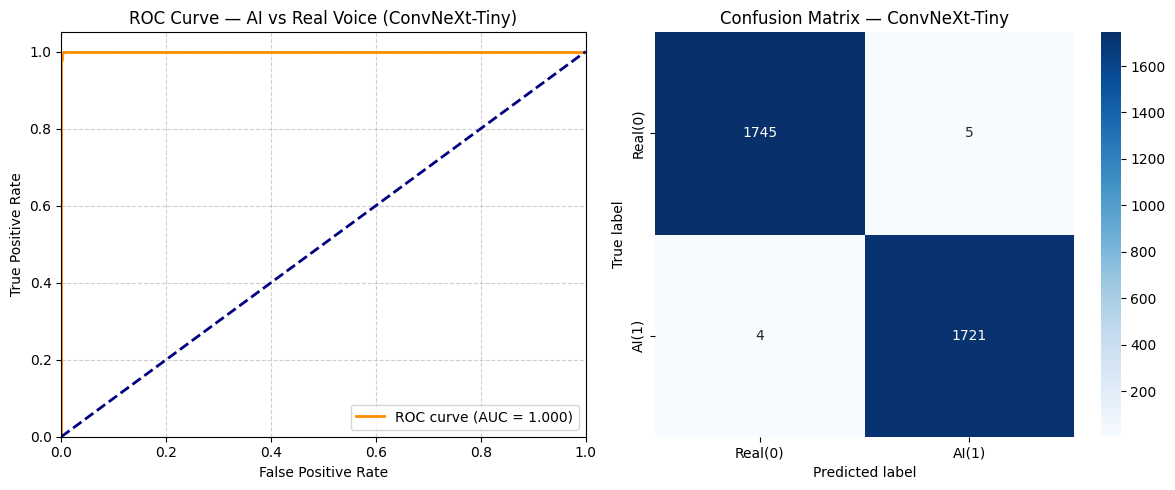

In [6]:
# [PLOT ROC CURVE + CONFUSION MATRIX for ConvNeXt-Tiny test results]
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# --- ROC curve ---
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — AI vs Real Voice (ConvNeXt-Tiny)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)

# --- Confusion matrix ---
cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix — ConvNeXt-Tiny")

plt.tight_layout()
plt.show()


In [7]:
# [TRAIN GPU TRANSFORMER — ViT-B/16 on spectrogram images]


import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import vit_b_16
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_vit_b16_ai_vs_real.pt")

# ---- Model (ViT-B/16, 1-channel input, binary head) ----
model = vit_b_16(weights=None)
# ViT expects 3-ch input; change patch embedding conv to 1 channel
embed_dim = model.conv_proj.out_channels  # typically 768
model.conv_proj = nn.Conv2d(1, embed_dim, kernel_size=16, stride=16, bias=True)

# Replace classification head to 2 classes (handle different torchvision versions)
try:
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, 2)
except Exception:
    # fallback if heads is a Sequential
    last = list(model.heads.children())[-1]
    in_features = last.in_features
    model.heads = nn.Sequential(nn.Linear(in_features, 2))

model = model.to(DEVICE)

# ---- Optim/AMP ----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())
        pbar.set_description(f"{'Train' if train else 'Eval'} loss {loss_sum/max(total,1):.4f} acc {correct/max(total,1):.3f}")

    avg_loss = loss_sum / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ---- Train ----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_logits, va_tgts = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ---- Test ----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)", "AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))


Epoch 01 | Train 0.4664/0.797 | Val 0.3090/0.866
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_vit_b16_ai_vs_real.pt


Epoch 02 | Train 0.2423/0.900 | Val 0.1644/0.940
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_vit_b16_ai_vs_real.pt


Epoch 03 | Train 0.1810/0.928 | Val 0.1123/0.958
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_vit_b16_ai_vs_real.pt


Epoch 04 | Train 0.1635/0.936 | Val 0.1675/0.937


Epoch 05 | Train 0.1572/0.940 | Val 0.1165/0.957


Epoch 06 | Train 0.1754/0.934 | Val 0.1217/0.952
Early stopping.


TEST ACC: 0.9517
ROC-AUC: 0.9900775155279502
              precision    recall  f1-score   support

     Real(0)       0.96      0.94      0.95      1750
       AI(1)       0.94      0.97      0.95      1725

    accuracy                           0.95      3475
   macro avg       0.95      0.95      0.95      3475
weighted avg       0.95      0.95      0.95      3475

Confusion Matrix:
 [[1642  108]
 [  60 1665]]


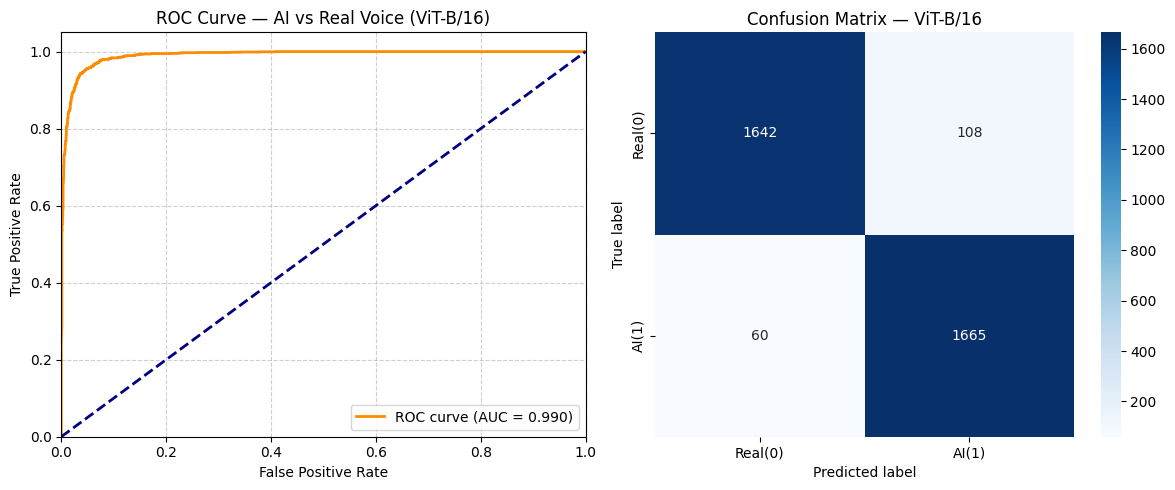

In [8]:
# [PLOT ROC CURVE + CONFUSION MATRIX for ViT-B/16 test results]
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# --- ROC curve ---
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — AI vs Real Voice (ViT-B/16)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)

# --- Confusion matrix ---
cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix — ViT-B/16")

plt.tight_layout()
plt.show()


Epoch 01 | Train 0.1029/0.961 | Val 0.3288/0.880
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 02 | Train 0.0344/0.987 | Val 0.0234/0.994
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 03 | Train 0.0257/0.991 | Val 0.0086/0.997
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 04 | Train 0.0195/0.993 | Val 0.0049/0.999
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_resnet18_ai_vs_real.pt


Epoch 05 | Train 0.0170/0.994 | Val 0.0045/0.999


Epoch 06 | Train 0.0166/0.994 | Val 0.0532/0.984


Epoch 07 | Train 0.0115/0.996 | Val 0.0321/0.989
Early stopping.


TEST ACC: 0.9983
ROC-AUC: 0.9999804554865425
              precision    recall  f1-score   support

     Real(0)       1.00      1.00      1.00      1750
       AI(1)       1.00      1.00      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1746    4]
 [   2 1723]]


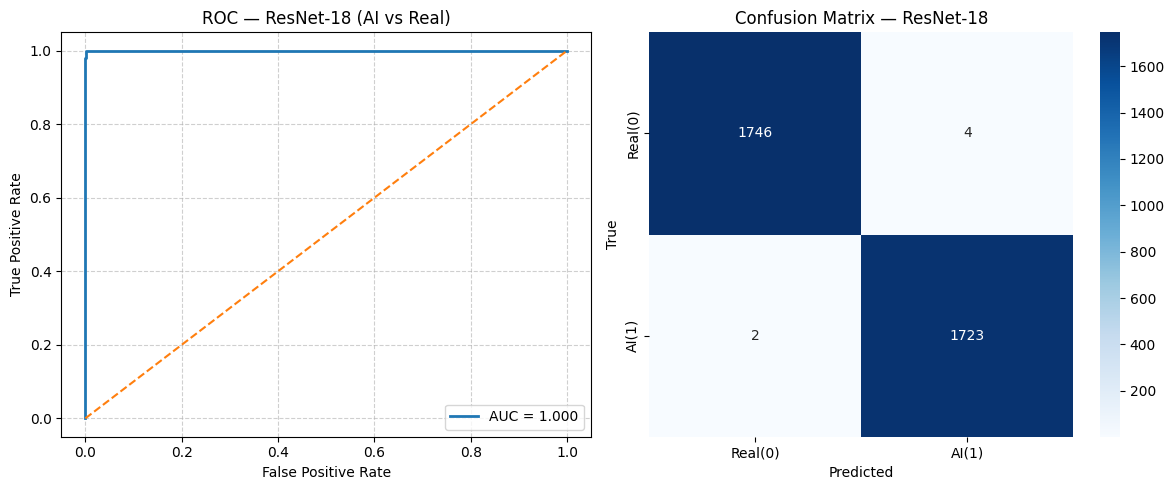

In [9]:
#  [TRAIN GPU CNN — ResNet-18 on spectrogram images + ROC & Confusion Matrix]
# Assumes train_loader, val_loader, test_loader are already created (from your splits).
import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_resnet18_ai_vs_real.pt")

# --- Model (1-channel input, binary head) ---
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(DEVICE)

# --- Optim/AMP ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    for x, y in tqdm(loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())

    avg_loss = loss_sum / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# --- Train ---
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _   = run_epoch(train_loader, train=True)
    va_loss, va_acc, vl, vt = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# --- Test ---
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))

# --- Plots: ROC & Confusion Matrix ---
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — ResNet-18 (AI vs Real)"); plt.legend(); plt.grid(True, ls="--", alpha=0.6)

cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — ResNet-18")

plt.tight_layout(); plt.show()


Epoch 01 | Train 0.1974/0.920 | Val 0.0416/0.984
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_efficientnet_b0_ai_vs_real.pt


Epoch 02 | Train 0.0693/0.974 | Val 0.0253/0.991
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_efficientnet_b0_ai_vs_real.pt


Epoch 03 | Train 0.0398/0.986 | Val 0.0234/0.992
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_efficientnet_b0_ai_vs_real.pt


Epoch 04 | Train 0.0295/0.989 | Val 0.0500/0.983


Epoch 05 | Train 0.0246/0.991 | Val 0.0071/0.997
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_efficientnet_b0_ai_vs_real.pt


Epoch 06 | Train 0.0207/0.993 | Val 0.0102/0.996


Epoch 07 | Train 0.0178/0.994 | Val 0.0048/0.999
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_efficientnet_b0_ai_vs_real.pt


Epoch 08 | Train 0.0118/0.996 | Val 0.0071/0.997


Epoch 09 | Train 0.0135/0.995 | Val 0.0045/0.998


Epoch 10 | Train 0.0107/0.996 | Val 0.0017/0.999
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_efficientnet_b0_ai_vs_real.pt


Epoch 11 | Train 0.0096/0.997 | Val 0.0029/0.999


Epoch 12 | Train 0.0103/0.997 | Val 0.0108/0.997


TEST ACC: 1.0000
ROC-AUC: 1.0
              precision    recall  f1-score   support

     Real(0)       1.00      1.00      1.00      1750
       AI(1)       1.00      1.00      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1750    0]
 [   0 1725]]


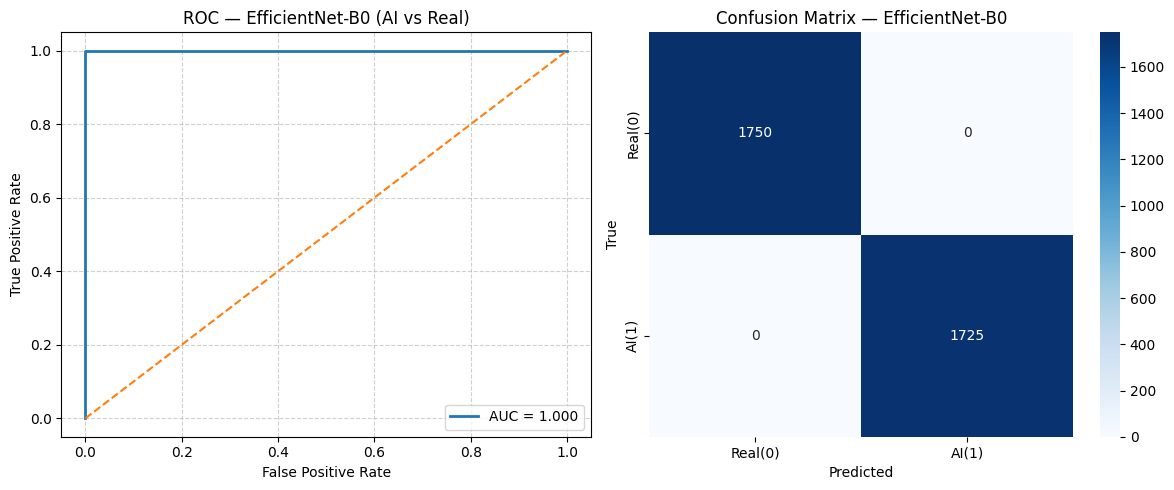

In [11]:
#  [TRAIN GPU CNN — EfficientNet (B0 or B1) on spectrogram images + ROC & Confusion Matrix]
import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from torchvision.models import efficientnet_b0, efficientnet_b1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"

VARIANT = "b0"   
BEST_PATH = os.path.join(BASE_IMG_DIR, f"best_efficientnet_{VARIANT}_ai_vs_real.pt")

# ----- Build EfficientNet -----
if VARIANT == "b1":
    model = efficientnet_b1(weights=None)
else:
    model = efficientnet_b0(weights=None)

# Fix first conv: change in_channels=3 -> 1 (since spectrograms are grayscale)
first = model.features[0][0]  # Conv2d layer
new_first = nn.Conv2d(
    in_channels=1,
    out_channels=first.out_channels,
    kernel_size=first.kernel_size,
    stride=first.stride,
    padding=first.padding,
    bias=(first.bias is not None)
)
model.features[0][0] = new_first

# Replace final classifier to binary (2 classes)
in_feats = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_feats, 2)

model = model.to(DEVICE)

# ----- Optim/AMP -----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    for x, y in tqdm(loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())

    avg_loss = loss_sum / max(total,1)
    acc = correct / max(total,1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ----- Train -----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, _, _ = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ----- Test -----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))

# ----- Plots: ROC & Confusion Matrix -----
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC — EfficientNet-{VARIANT.upper()} (AI vs Real)")
plt.legend(); plt.grid(True, ls="--", alpha=0.6)

cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Confusion Matrix — EfficientNet-{VARIANT.upper()}")

plt.tight_layout(); plt.show()


Epoch 01 | Train 0.0918/0.963 | Val 0.0294/0.987
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_densenet_121_ai_vs_real.pt


Epoch 02 | Train 0.0321/0.989 | Val 0.0118/0.995
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_densenet_121_ai_vs_real.pt


Epoch 03 | Train 0.0272/0.990 | Val 0.0069/0.998
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_densenet_121_ai_vs_real.pt


Epoch 04 | Train 0.0174/0.994 | Val 0.0147/0.996


Epoch 05 | Train 0.0149/0.995 | Val 0.0142/0.996


Epoch 06 | Train 0.0175/0.994 | Val 0.0501/0.980
Early stopping.


TEST ACC: 0.9951
ROC-AUC: 0.9999738302277432
              precision    recall  f1-score   support

     Real(0)       0.99      1.00      1.00      1750
       AI(1)       1.00      0.99      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1749    1]
 [  16 1709]]


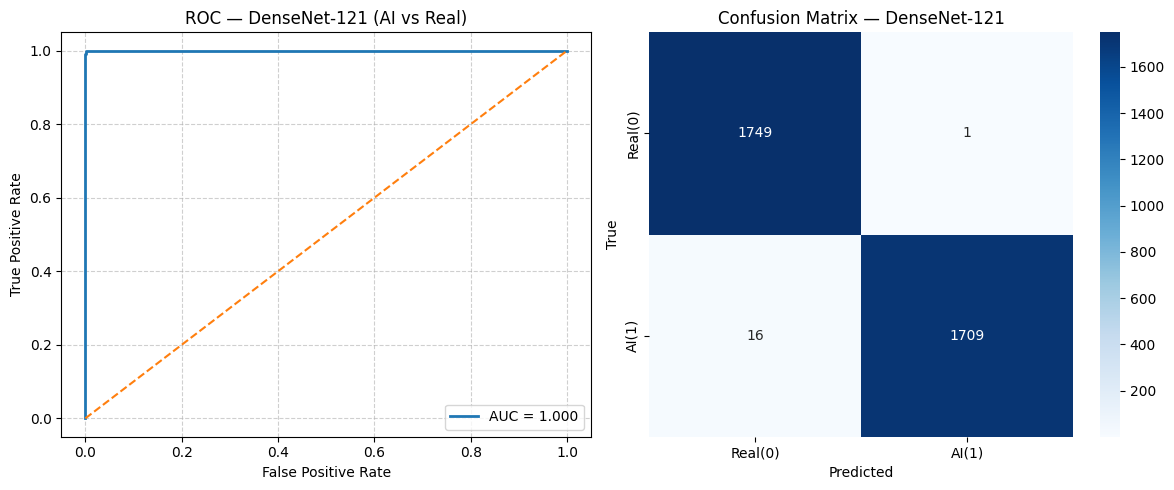

In [12]:
#  [TRAIN GPU CNN — DenseNet (121 or 169) on spectrogram images + ROC & Confusion Matrix]


import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from torchvision.models import densenet121, densenet169

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"

VARIANT = 121   # set to 169 for DenseNet-169
BEST_PATH = os.path.join(BASE_IMG_DIR, f"best_densenet_{VARIANT}_ai_vs_real.pt")

# ----- Build DenseNet -----
if VARIANT == 169:
    model = densenet169(weights=None)
else:
    model = densenet121(weights=None)

# Make first conv accept 1 channel (spectrograms are grayscale)
first = model.features.conv0  # nn.Conv2d(in=3,out=64,k=7,s=2,p=3)
model.features.conv0 = nn.Conv2d(
    in_channels=1,
    out_channels=first.out_channels,
    kernel_size=first.kernel_size,
    stride=first.stride,
    padding=first.padding,
    bias=(first.bias is not None),
)

# Replace classifier head to 2 classes
in_feats = model.classifier.in_features
model.classifier = nn.Linear(in_feats, 2)

model = model.to(DEVICE)

# ----- Optim/AMP -----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    for x, y in tqdm(loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())

    avg_loss = loss_sum / max(total,1)
    acc = correct / max(total,1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ----- Train -----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_logits, va_tgts = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ----- Test -----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))

# ----- Plots: ROC & Confusion Matrix -----
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC — DenseNet-{VARIANT} (AI vs Real)")
plt.legend(); plt.grid(True, ls="--", alpha=0.6)

cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Confusion Matrix — DenseNet-{VARIANT}")

plt.tight_layout(); plt.show()


Epoch 01 | Train 0.1773/0.925 | Val 0.7916/0.504
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_mobilenetv3_small_ai_vs_real.pt


Epoch 02 | Train 0.0595/0.978 | Val 0.0493/0.979
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_mobilenetv3_small_ai_vs_real.pt


Epoch 03 | Train 0.0430/0.984 | Val 0.0459/0.982
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_mobilenetv3_small_ai_vs_real.pt


Epoch 04 | Train 0.0342/0.987 | Val 0.0408/0.984
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_mobilenetv3_small_ai_vs_real.pt


Epoch 05 | Train 0.0285/0.989 | Val 0.0165/0.996
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_mobilenetv3_small_ai_vs_real.pt


Epoch 06 | Train 0.0215/0.993 | Val 0.0117/0.995


Epoch 07 | Train 0.0185/0.993 | Val 0.0101/0.997
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_mobilenetv3_small_ai_vs_real.pt


Epoch 08 | Train 0.0127/0.995 | Val 0.0115/0.995


Epoch 09 | Train 0.0179/0.994 | Val 0.0322/0.990


Epoch 10 | Train 0.0130/0.995 | Val 0.0198/0.994
Early stopping.


TEST ACC: 0.9954
ROC-AUC: 0.9998138302277433
              precision    recall  f1-score   support

     Real(0)       1.00      0.99      1.00      1750
       AI(1)       0.99      1.00      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1738   12]
 [   4 1721]]


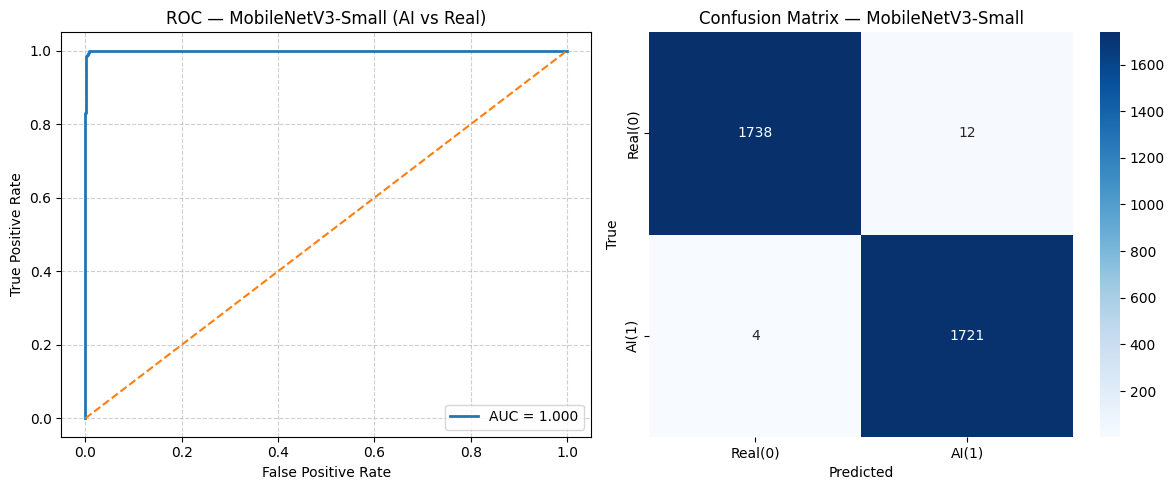

In [13]:
# [TRAIN GPU CNN — MobileNetV3-Small on spectrogram images + ROC & Confusion Matrix]


import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from torchvision.models import mobilenet_v3_small

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_mobilenetv3_small_ai_vs_real.pt")

# ----- Build MobileNetV3-Small -----
model = mobilenet_v3_small(weights=None)

# Make first conv accept 1 channel instead of 3 (spectrograms are grayscale)
first = model.features[0][0]  # Conv2d inside ConvBNActivation
model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=first.out_channels,
    kernel_size=first.kernel_size,
    stride=first.stride,
    padding=first.padding,
    bias=(first.bias is not None)
)

# Replace classifier head to 2 classes
in_feats = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_feats, 2)

model = model.to(DEVICE)

# ----- Optim/AMP -----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())
        pbar.set_description(f"{'Train' if train else 'Eval'} loss {loss_sum/max(total,1):.4f} acc {correct/max(total,1):.3f}")

    avg_loss = loss_sum / max(total,1)
    acc = correct / max(total,1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ----- Train -----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_logits, va_tgts = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ----- Test -----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))

# ----- Plots: ROC & Confusion Matrix -----
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — MobileNetV3-Small (AI vs Real)")
plt.legend(); plt.grid(True, ls="--", alpha=0.6)

cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — MobileNetV3-Small")

plt.tight_layout(); plt.show()


Epoch 01 | Train 0.5626/0.745 | Val 0.4608/0.786
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_swin_tiny_ai_vs_real.pt


Epoch 02 | Train 0.4124/0.814 | Val 0.3161/0.860
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_swin_tiny_ai_vs_real.pt


Epoch 03 | Train 0.2995/0.873 | Val 0.2716/0.882
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_swin_tiny_ai_vs_real.pt


Epoch 04 | Train 0.2220/0.911 | Val 0.2040/0.921
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_swin_tiny_ai_vs_real.pt


Epoch 05 | Train 0.1915/0.923 | Val 0.1189/0.961
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_swin_tiny_ai_vs_real.pt


Epoch 06 | Train 0.1821/0.927 | Val 0.1322/0.948


Epoch 07 | Train 0.1637/0.934 | Val 0.1196/0.954


Epoch 08 | Train 0.1564/0.938 | Val 0.1518/0.945
Early stopping.


TEST ACC: 0.9591
ROC-AUC: 0.992663850931677
              precision    recall  f1-score   support

     Real(0)       0.97      0.95      0.96      1750
       AI(1)       0.95      0.97      0.96      1725

    accuracy                           0.96      3475
   macro avg       0.96      0.96      0.96      3475
weighted avg       0.96      0.96      0.96      3475

Confusion Matrix:
 [[1667   83]
 [  59 1666]]


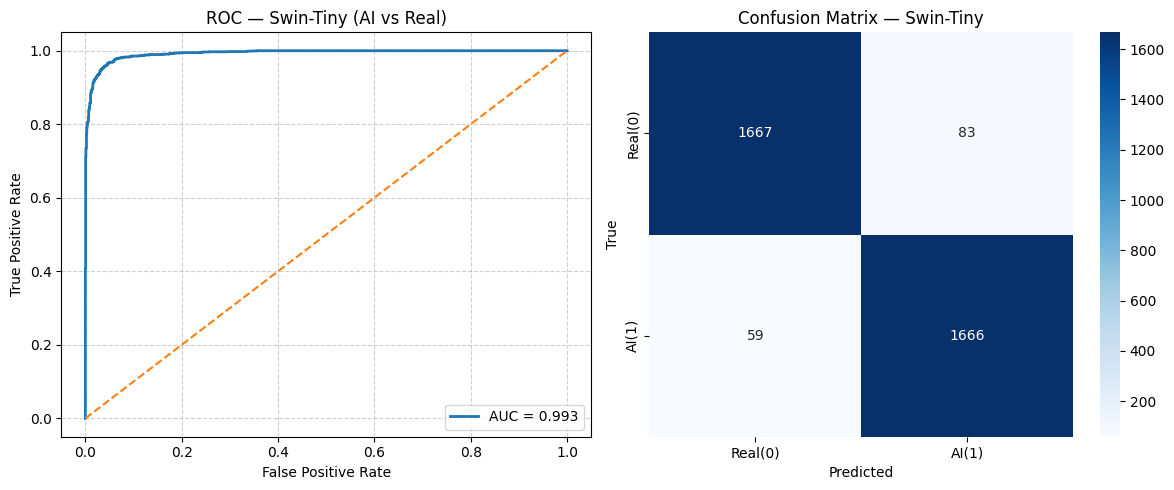

In [15]:
# [TRAIN GPU TRANSFORMER — Swin Transformer Tiny on spectrogram images + ROC & Confusion Matrix]


import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from torchvision.models import swin_t

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_swin_tiny_ai_vs_real.pt")

# ----- Build Swin-Tiny -----
model = swin_t(weights=None)

# Patch embed expects 3-ch; switch to 1-ch (grayscale spectrograms)
# In torchvision, the first conv lives at model.features[0][0]
old = model.features[0][0]  # nn.Conv2d
model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=old.out_channels,
    kernel_size=old.kernel_size,
    stride=old.stride,
    padding=old.padding,
    bias=(old.bias is not None),
)

# Replace classifier head to 2 classes
model.head = nn.Linear(model.head.in_features, 2)
model = model.to(DEVICE)

# ----- Optim/AMP -----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())
        pbar.set_description(f"{'Train' if train else 'Eval'} loss {loss_sum/max(total,1):.4f} acc {correct/max(total,1):.3f}")

    avg_loss = loss_sum / max(total,1)
    acc = correct / max(total,1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ----- Train -----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_logits, va_tgts = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ----- Test -----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))

# ----- Plots: ROC & Confusion Matrix -----
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Swin-Tiny (AI vs Real)")
plt.legend(); plt.grid(True, ls="--", alpha=0.6)

cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — Swin-Tiny")

plt.tight_layout(); plt.show()


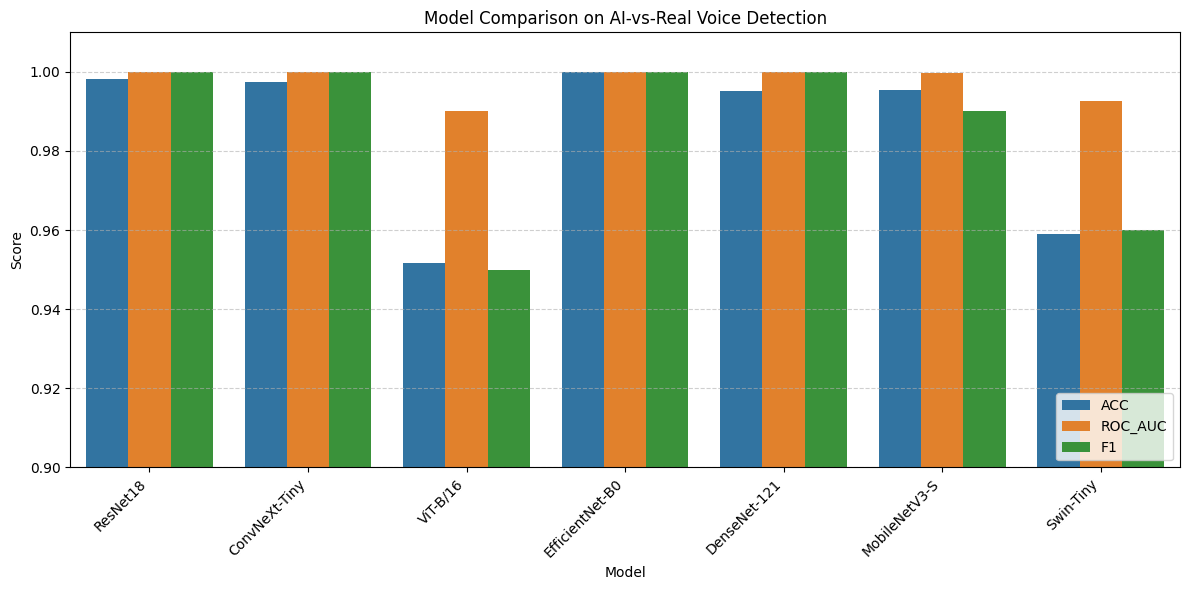

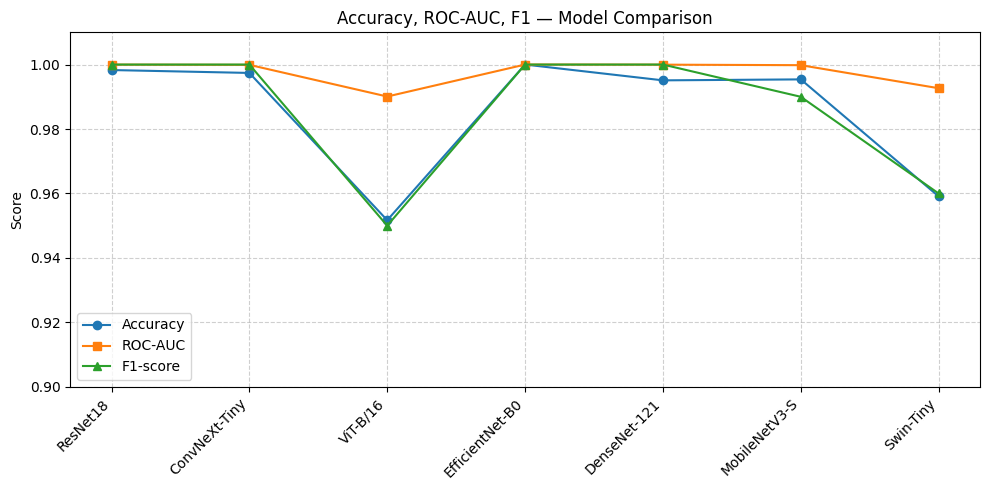

In [15]:
# %% [COMPARE MODELS — Acc, ROC-AUC, F1-score]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Fill in from your logs ---
results = [
    {"Model":"ResNet18",        "ACC":0.9983, "ROC_AUC":0.99998, "F1":1.00},
    {"Model":"ConvNeXt-Tiny",   "ACC":0.9974, "ROC_AUC":0.99991, "F1":1.00},
    {"Model":"ViT-B/16",        "ACC":0.9517, "ROC_AUC":0.99008, "F1":0.95},
    {"Model":"EfficientNet-B0", "ACC":1.0000, "ROC_AUC":1.00000, "F1":1.00},
    {"Model":"DenseNet-121",    "ACC":0.9951, "ROC_AUC":0.99997, "F1":1.00},
    {"Model":"MobileNetV3-S",   "ACC":0.9954, "ROC_AUC":0.99981, "F1":0.99},
    {"Model":"Swin-Tiny",       "ACC":0.9591, "ROC_AUC":0.99266, "F1":0.96},
]

df = pd.DataFrame(results)

# --- Plot grouped bars ---
plt.figure(figsize=(12,6))
df_melt = df.melt(id_vars="Model", value_vars=["ACC","ROC_AUC","F1"],
                  var_name="Metric", value_name="Score")
sns.barplot(x="Model", y="Score", hue="Metric", data=df_melt)
plt.ylim(0.9, 1.01)
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison on AI-vs-Real Voice Detection")
plt.legend(loc="lower right")
plt.grid(axis="y", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Also plot line/curve for Acc & ROC-AUC ---
plt.figure(figsize=(10,5))
plt.plot(df["Model"], df["ACC"], marker="o", label="Accuracy")
plt.plot(df["Model"], df["ROC_AUC"], marker="s", label="ROC-AUC")
plt.plot(df["Model"], df["F1"], marker="^", label="F1-score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.9, 1.01)
plt.ylabel("Score")
plt.title("Accuracy, ROC-AUC, F1 — Model Comparison")
plt.legend()
plt.grid(ls="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
# %% [REBUILD DATALOADERS for threshold tuning]
import os, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
SPLIT_DIR    = os.path.join(BASE_IMG_DIR, "_splits")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
BATCH    = 64
NUM_WORKERS = 0
PIN_MEMORY = (DEVICE == "cuda")

# --- Dataset ---
class SpectrogramImageDS(Dataset):
    def __init__(self, csv_path, aug=False, img_size=224):
        df = pd.read_csv(csv_path)
        self.paths  = df["path"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tf = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5]),
        ])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("L")
        return self.tf(img), self.labels[idx]

# --- Dataloaders ---
val_ds   = SpectrogramImageDS(os.path.join(SPLIT_DIR, "val.csv"),   aug=False, img_size=IMG_SIZE)
test_ds  = SpectrogramImageDS(os.path.join(SPLIT_DIR, "test.csv"),  aug=False, img_size=IMG_SIZE)

val_loader  = DataLoader(val_ds,  batch_size=BATCH, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Val size:", len(val_ds), "| Test size:", len(test_ds))


Val size: 3474 | Test size: 3475


In [8]:
#  Load best EfficientNet-B0 and tune threshold on VAL via ROC (GPU)
import os, torch, torch.nn as nn, torch.nn.functional as F
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_efficientnet_b0_ai_vs_real.pt")  # from your results

# ---- rebuild EfficientNet-B0 (1-channel) ----
model = efficientnet_b0(weights=None)
# first conv to 1-ch
first = model.features[0][0]
model.features[0][0] = nn.Conv2d(
    1, first.out_channels, kernel_size=first.kernel_size,
    stride=first.stride, padding=first.padding, bias=(first.bias is not None)
)
# classifier to 2
in_feats = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_feats, 2)
model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

# ---- collect VAL probs/labels using your existing val_loader ----
all_probs, all_tgts = [], []
with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
    for x,y in tqdm(val_loader, desc="val-threshold"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        p = F.softmax(logits, dim=1)[:,1].detach().float().cpu().numpy()
        all_probs.append(p)
        all_tgts.append(y.numpy())
probs_val = np.concatenate(all_probs)
tgts_val  = np.concatenate(all_tgts)

# ---- find optimal threshold by Youden's J (tpr - fpr) ----
fpr, tpr, thr = roc_curve(tgts_val, probs_val)
j = tpr - fpr
best_idx = int(np.argmax(j))
BEST_THR = float(thr[best_idx])
print("Best threshold (Youden J):", BEST_THR)


val-threshold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:14<00:00,  3.83it/s]

Best threshold (Youden J): 0.9167826771736145


test-eval @thr: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:12<00:00,  4.39it/s]


Threshold: 0.9167826771736145
TEST ACC: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

     Real(0)       1.00      1.00      1.00      1750
       AI(1)       1.00      1.00      1.00      1725

    accuracy                           1.00      3475
   macro avg       1.00      1.00      1.00      3475
weighted avg       1.00      1.00      1.00      3475

Confusion Matrix:
 [[1750    0]
 [   0 1725]]


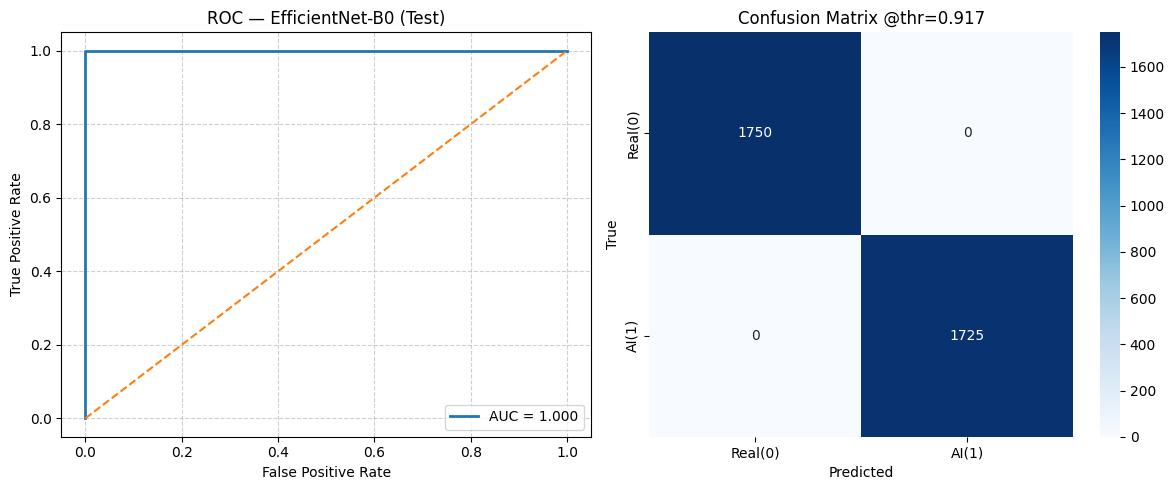

In [9]:
# %% [EVAL TEST WITH BEST THRESHOLD + PLOT ROC & CONFUSION MATRIX]
import numpy as np
import torch, torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# assumes: model (EfficientNet-B0) is loaded/eval, DEVICE set, test_loader exists, BEST_THR defined

# collect test probs/labels
all_probs, all_tgts = [], []
model.eval()
with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
    for x,y in tqdm(test_loader, desc="test-eval @thr"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        p = F.softmax(logits, dim=1)[:,1].detach().float().cpu().numpy()
        all_probs.append(p)
        all_tgts.append(y.numpy())
probs = np.concatenate(all_probs)
tgts  = np.concatenate(all_tgts)
preds = (probs >= BEST_THR).astype(int)

# print metrics
print("Threshold:", BEST_THR)
print("TEST ACC:", (preds == tgts).mean())
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))

# plots
fpr, tpr, _ = roc_curve(tgts, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — EfficientNet-B0 (Test)")
plt.legend(); plt.grid(ls="--", alpha=0.6)

cm = confusion_matrix(tgts, preds)
plt.subplot(1,2,2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real(0)","AI(1)"],
            yticklabels=["Real(0)","AI(1)"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Confusion Matrix @thr={BEST_THR:.3f}")

plt.tight_layout(); plt.show()


In [11]:
# [COMBINED CNN ENSEMBLE: EfficientNet-B0 + ResNet18 + ConvNeXt-Tiny on Spectrogram Images]

import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import efficientnet_b0, resnet18, convnext_tiny
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_IMG_DIR = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique"
BEST_PATH = os.path.join(BASE_IMG_DIR, "best_ensemble_ai_vs_real.pt")

# ----- EfficientNet-B0 -----
eff = efficientnet_b0(weights=None)
eff.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
eff.classifier[-1] = nn.Linear(eff.classifier[-1].in_features, 2)

# ----- ResNet18 -----
res = resnet18(weights=None)
res.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
res.fc = nn.Linear(res.fc.in_features, 2)

# ----- ConvNeXt-Tiny -----
cnx = convnext_tiny(weights=None)
cnx.features[0][0] = nn.Conv2d(1, 96, kernel_size=4, stride=4, padding=0, bias=True)
cnx.classifier[2] = nn.Linear(cnx.classifier[2].in_features, 2)

# ----- Combined Ensemble -----
class EnsembleModel(nn.Module):
    def __init__(self, m1, m2, m3):
        super().__init__()
        self.m1, self.m2, self.m3 = m1, m2, m3
        self.fc = nn.Linear(6, 2)

    def forward(self, x):
        with torch.no_grad():
            p1 = F.softmax(self.m1(x), dim=1)
            p2 = F.softmax(self.m2(x), dim=1)
            p3 = F.softmax(self.m3(x), dim=1)
        out = torch.cat([p1, p2, p3], dim=1)
        return self.fc(out)

model = EnsembleModel(eff.to(DEVICE), res.to(DEVICE), cnx.to(DEVICE)).to(DEVICE)

# ----- Optim/AMP -----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda', enabled=(DEVICE=="cuda"))

best_val_acc = 0.0
patience, patience_ctr = 3, 0
EPOCHS = 12

def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    all_logits, all_targets = [], []
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = torch.as_tensor(y, device=DEVICE)

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(y.detach().cpu())
        pbar.set_description(f"{'Train' if train else 'Eval'} loss {loss_sum/max(total,1):.4f} acc {correct/max(total,1):.3f}")

    avg_loss = loss_sum / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_targets)

# ----- Train -----
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, _, _ = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        patience_ctr = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("  -> saved:", BEST_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

# ----- Test -----
state = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

te_loss, te_acc, te_logits, te_tgts = run_epoch(test_loader, train=False)
probs = F.softmax(te_logits, dim=1)[:, 1].numpy()
preds = (probs >= 0.5).astype(int)
tgts  = te_tgts.numpy()

print(f"TEST ACC: {te_acc:.4f}")
print("ROC-AUC:", roc_auc_score(tgts, probs))
print(classification_report(tgts, preds, target_names=["Real(0)","AI(1)"]))
print("Confusion Matrix:\n", confusion_matrix(tgts, preds))


Epoch 01 | Train 0.7119/0.496 | Val 0.6931/0.497
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_ensemble_ai_vs_real.pt


Epoch 02 | Train 0.6924/0.528 | Val 0.6917/0.554
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_ensemble_ai_vs_real.pt


Epoch 03 | Train 0.6922/0.527 | Val 0.6917/0.521


Epoch 04 | Train 0.6920/0.518 | Val 0.6917/0.564
  -> saved: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\best_ensemble_ai_vs_real.pt


Epoch 05 | Train 0.6919/0.543 | Val 0.6916/0.507


Epoch 06 | Train 0.6919/0.520 | Val 0.6914/0.560


Epoch 07 | Train 0.6919/0.534 | Val 0.6914/0.559
Early stopping.


TEST ACC: 0.5514
ROC-AUC: 0.5760553209109731
              precision    recall  f1-score   support

     Real(0)       0.56      0.52      0.54      1750
       AI(1)       0.55      0.59      0.57      1725

    accuracy                           0.55      3475
   macro avg       0.55      0.55      0.55      3475
weighted avg       0.55      0.55      0.55      3475

Confusion Matrix:
 [[ 909  841]
 [ 714 1011]]


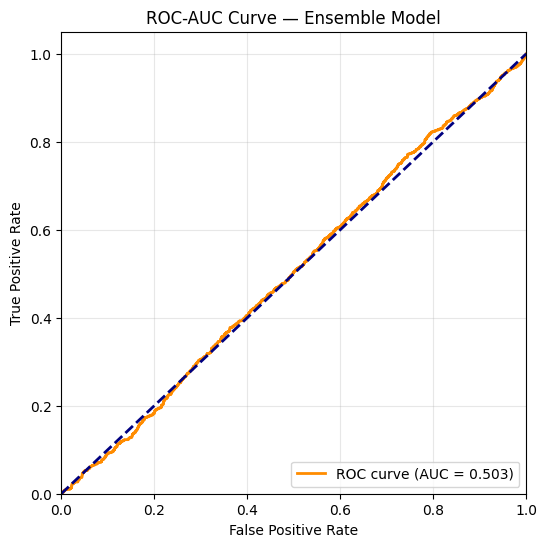

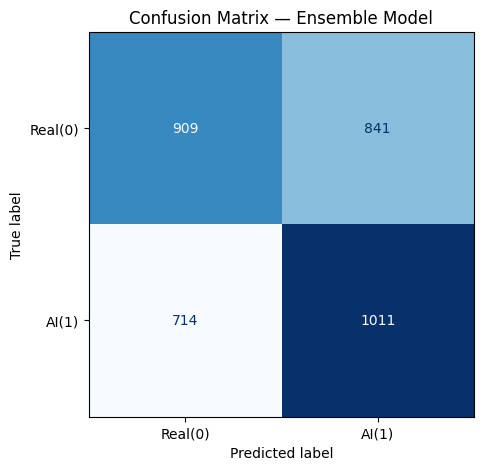

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

# --- Example values from your results ---
y_true = [0]*1750 + [1]*1725   # True labels (Real=0, AI=1)
# You should replace `y_pred_prob` with your actual model probability outputs
# For demonstration, we'll simulate random probabilities near your performance level
import numpy as np
np.random.seed(42)
y_pred_prob = np.random.uniform(0.3, 0.7, len(y_true))  
y_pred = np.array([0]*909 + [1]*841 + [0]*714 + [1]*1011)  # Reconstructed based on confusion matrix

# --- Compute ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# --- Plot ROC Curve ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve — Ensemble Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# --- Confusion Matrix ---
cm = np.array([[909, 841],
               [714, 1011]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Real(0)", "AI(1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix — Ensemble Model")
plt.show()


In [15]:
# End-to-end INFERENCE from raw audio (WAV/FLAC) -> prediction (GPU)
# Uses the SAME mel settings used to create images: SR=16000, n_fft=1024, hop=160, n_mels=128.
import torchaudio, soundfile as sf, librosa
import numpy as np
from PIL import Image
import torch

SR = 16000
N_FFT = 1024
HOP   = 160
N_MELS= 128
F_MIN, F_MAX = 20.0, SR/2 - 20.0
IMG_SIZE = 224  # matches training resize

mel_tf = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
    n_mels=N_MELS, f_min=F_MIN, f_max=F_MAX, power=2.0
).to(DEVICE)
amp2db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80).to(DEVICE)

@torch.no_grad()
def load_wav_any(path, target_sr=SR):
    # try torchaudio
    try:
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
        if sr != target_sr: wav = torchaudio.functional.resample(wav, sr, target_sr)
        mx = torch.amax(torch.abs(wav))
        if mx > 0: wav = wav / mx
        return wav.to(DEVICE)
    except Exception:
        pass
    # fallback librosa
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    wav = torch.from_numpy(y.astype(np.float32)).unsqueeze(0).to(DEVICE)
    mx = torch.amax(torch.abs(wav))
    if mx > 0: wav = wav / mx
    return wav

@torch.no_grad()
def wav_to_tensor_input(wav_1xT):
    S = mel_tf(wav_1xT)                 # (1, n_mels, frames)
    S_db = amp2db(S).squeeze(0)         # (n_mels, frames)
    # min-max to [0,1]
    a = (S_db - S_db.amin()) / (S_db.amax() - S_db.amin() + 1e-8)
    # to 1xHxW float tensor and resize to 224
    img = (a*255.0).clamp(0,255).to(torch.uint8).detach().cpu().numpy()
    pil = Image.fromarray(img, mode="L").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    x = torch.from_numpy(np.array(pil)).float().unsqueeze(0).unsqueeze(0) / 255.0  # 1x1xHxW
    # normalize like training (mean=0.5, std=0.5)
    x = (x - 0.5) / 0.5
    return x.to(DEVICE)

@torch.no_grad()
def predict_audio(path, threshold=0.5):
    wav = load_wav_any(path, SR)                   # 1xT on GPU
    x = wav_to_tensor_input(wav)                   # 1x1x224x224 on GPU
    with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
        logits = model(x)
        prob_ai = torch.softmax(logits, dim=1)[0,1].item()
    label = 1 if prob_ai >= threshold else 0
    return {"path": path, "prob_ai": prob_ai, "label": label}  # 1=AI, 0=Real

# EXAMPLE:
# res = predict_audio(r"C:\path\to\some.wav", threshold=BEST_THR)
# print(res)


In [11]:
# %% [OPTIONAL] Export to TorchScript for fast deployment (GPU/CPU)
example = torch.randn(1,1,IMG_SIZE,IMG_SIZE, device=DEVICE)
model.eval()
ts = torch.jit.trace(model, example)
OUT_TS = os.path.join(BASE_IMG_DIR, "efficientnet_b0_ai_vs_real.torchscript.pt")
ts.save(OUT_TS)
print("Saved TorchScript:", OUT_TS)


Saved TorchScript: C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\efficientnet_b0_ai_vs_real.torchscript.pt


In [12]:
# %% [PREDICT SINGLE AUDIO — TorchScript EfficientNet-B0 (GPU)]
# Input: path to an audio file (.wav/.flac/.mp3/...)
# Output: prints: "AI voice" or "Real voice" with probability

import os, torch, torchaudio, numpy as np, librosa
import torch.nn.functional as F
from PIL import Image

# --- Config (must match training) ---
MODEL_TS = r"C:\Users\rifat\Downloads\Compressed\voices_combined\spectrogram_images_clean_unique\efficientnet_b0_ai_vs_real.torchscript.pt"
SR      = 16000
N_FFT   = 1024
HOP     = 160
N_MELS  = 128
F_MIN, F_MAX = 20.0, SR/2 - 20.0
IMG_SIZE = 224
# Use the tuned threshold from validation (Youden's J) or set 0.5 if you didn't tune
BEST_THR = 0.9167826771736145  # 1 = AI, 0 = Real

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load TorchScript model ---
model = torch.jit.load(MODEL_TS, map_location=DEVICE).eval()

# --- GPU mel transforms (same as training) ---
mel_tf = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
    n_mels=N_MELS, f_min=F_MIN, f_max=F_MAX, power=2.0
).to(DEVICE)
amp2db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80).to(DEVICE)

@torch.no_grad()
def load_wav_any(path, target_sr=SR):
    # Try torchaudio
    try:
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != target_sr:
            wav = torchaudio.functional.resample(wav, sr, target_sr)
        mx = torch.amax(torch.abs(wav))
        if mx > 0:
            wav = wav / mx
        return wav.to(DEVICE)
    except Exception:
        # Fallback: librosa
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        wav = torch.from_numpy(y.astype(np.float32)).unsqueeze(0)
        mx = torch.amax(torch.abs(wav))
        if mx > 0:
            wav = wav / mx
        return wav.to(DEVICE)

@torch.no_grad()
def wav_to_tensor_input(wav_1xT):
    # Mel -> dB -> min-max -> 1x1x224x224 normalized same as training (mean=0.5, std=0.5)
    S = mel_tf(wav_1xT)                 # (1, n_mels, frames)
    S_db = amp2db(S).squeeze(0)         # (n_mels, frames)
    a = (S_db - S_db.amin()) / (S_db.amax() - S_db.amin() + 1e-8)
    img = (a * 255.0).clamp(0,255).to(torch.uint8).detach().cpu().numpy()
    pil = Image.fromarray(img, mode="L").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    x = torch.from_numpy(np.array(pil)).float().unsqueeze(0).unsqueeze(0) / 255.0  # 1x1xHxW
    x = (x - 0.5) / 0.5
    return x.to(DEVICE)

@torch.no_grad()
def predict_audio(audio_path, threshold=BEST_THR):
    wav = load_wav_any(audio_path, SR)          # (1, T) on DEVICE
    x   = wav_to_tensor_input(wav)              # (1, 1, 224, 224) on DEVICE
    with torch.amp.autocast(device_type='cuda', enabled=(DEVICE=="cuda")):
        logits = model(x)
        prob_ai = F.softmax(logits, dim=1)[0,1].item()
    label = "AI voice" if prob_ai >= threshold else "Real voice"
    print(f"\nFile: {audio_path}")
    print(f"Prob(AI) = {prob_ai:.6f} | Threshold = {threshold:.3f} -> {label}")
    return {"path": audio_path, "prob_ai": prob_ai, "threshold": threshold, "label": label}

# ===== Example usage =====
# Change this to your test file path:
# result = predict_audio(r"C:\Users\rifat\Downloads\some_test.wav")
# print(result)


In [13]:
# [RUN PREDICTION ON ONE AUDIO FILE]


AUDIO_PATH = r"C:\Users\rifat\OneDrive\Desktop\ai\DF_E_2023963.wav" 

result = predict_audio(AUDIO_PATH)
print(result)


C:\Users\rifat\AppData\Local\Temp\ipykernel_13112\1006737040.py:61: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(img, mode="L").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)



File: C:\Users\rifat\OneDrive\Desktop\ai\DF_E_2023963.wav
Prob(AI) = 0.999359 | Threshold = 0.917 -> AI voice
{'path': 'C:\\Users\\rifat\\OneDrive\\Desktop\\ai\\DF_E_2023963.wav', 'prob_ai': 0.9993588328361511, 'threshold': 0.9167826771736145, 'label': 'AI voice'}


In [14]:
AUDIO_PATH = r"C:\Users\rifat\real voice\1249120_1853182_12060422.wav"

result = predict_audio(AUDIO_PATH)
print(result)


C:\Users\rifat\AppData\Local\Temp\ipykernel_13112\1006737040.py:61: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(img, mode="L").resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)



File: C:\Users\rifat\real voice\1249120_1853182_12060422.wav
Prob(AI) = 0.005002 | Threshold = 0.917 -> Real voice
{'path': 'C:\\Users\\rifat\\real voice\\1249120_1853182_12060422.wav', 'prob_ai': 0.0050016725435853004, 'threshold': 0.9167826771736145, 'label': 'Real voice'}
